# diag_dissip_wape

plot online diagnostics HKE and estimate of APE, using online diag low-pass filtered

also plot for paper

In [1]:
%matplotlib notebook
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

import numpy as np
from netCDF4 import Dataset
from PIL import Image, ImageDraw
import json
import pandas as pd
import sys, os

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = KRYPTON+"local_ruchba/"
HOME = os.getenv('HOME')+"/"

In [2]:
simul = 'luckym2'

path_data = KRYPTON+"local_ruchba/{0}/{1}_diags_ek_lf_extracted.nc".format(simul.upper(),simul) 
path_dape = RUCHBA+"{0}/{1}_diag_diss_ape.nc".format(simul.upper(),simul)
path_grid = KRYPTON+'lucky_corgrd.nc'
pdatout = HOME+"working_on/NRJ_flux_diag/{}_NRJ_diags".format(simul)
doms_file = "../NRJ_flux_diag/subdomains_lucky.json"

dosavefig = False
picdir = "./pictures/"

hmin = 100 # minimum depth for mask
rho0 = 1025

In [3]:
### load grid and data
nc = Dataset(path_grid, "r")
h = nc.variables['h'][:]
lon = nc.variables['lon_rho'][:]
lat = nc.variables['lat_rho'][:]
pm = nc.variables['pm'][:]
pn = nc.variables['pn'][:]
nc.close()
dx, dy = (1./pm).mean(), (1./pn).mean()
Ny, Nx = h.shape

nc = Dataset(path_data)
data = {}
print("loading", end=" ")
for key,val in nc.variables.items():
    if val.ndim == 3:
        data[key] = val[:].mean(axis=0)*rho0*pm*pn
        print(key, end=", ")
print("finished")
nc.close()

# correct vmix to exclude drag and baro
data['ke_vmix'] -= data['ke_drag']+data['ke_wind']+data['ke_baro']
data['ke_hadv'] -= data['ke_hdiff']
data['ke_prsgrd'] += data['ke_baro']

# load ape dissip
nc = Dataset(path_dape)
xi = nc.variables['xi_rho'][:]
eta = nc.variables['eta_rho'][:]
dape = nc.variables['dape'][:].mean(axis=0)
nc.close()
nsx = xi[1]-xi[0]

print("loaded ape, subsampled every {:d} points".format(nsx))

loading ke_hadv, ke_hdiff, ke_vadv, ke_cor, ke_prsgrd, ke_hmix, ke_vmix, ke_rate, ke_vol, ke_nudg, ke_wind, ke_drag, ke_baro, finished
loaded ape, subsampled every 2 points


<IPython.core.display.Javascript object>


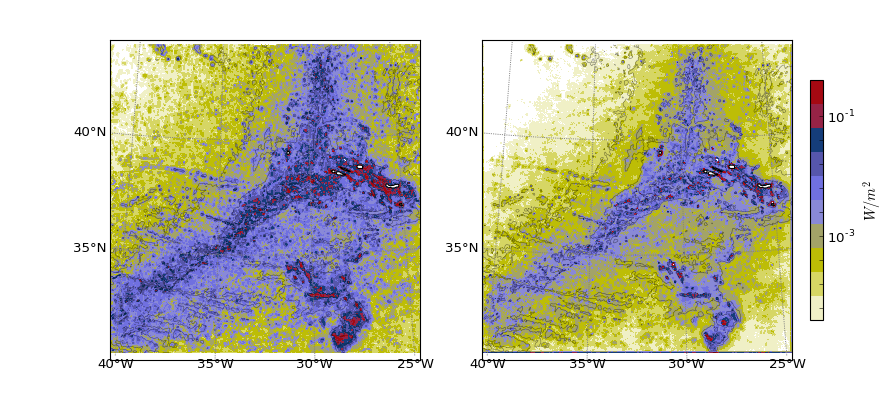

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/lib/python3/dist-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
/usr/lib/python3/dist-packages/matplotlib/contour.py:1537: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)


total: 7.3 GW, mean: 3.25 mW/m^2
hdiff: 4.4 GW, mean: 1.95 mW/m^2
vmix-drag: 0.6 GW, mean: 0.27 mW/m^2
drag: 2.3 GW, mean: 1.04 mW/m^2
dAPE: 2.4 GW, mean: 1.09 mW/m^2


In [4]:
toplot = data['ke_hdiff'] + data['ke_vmix'] + data['ke_drag'] #
toplot = -toplot
mask = h>hmin

# plotting parameters
fs       = 12
proj     = 'lcc'
res      = 'i'
stride   = 5
Lx,Ly    = dx*Nx, dy*Ny # extend in m
cmap = plt.get_cmap('gist_stern_r')
zlevs=[0,2000,3500]
topocol='k'     # isobath. contour color
grdcol='gray'   # grid color
mascale = "log" # 'linear'# 
if mascale == "linear":
    valmax = 0.1
    levels = np.linspace(0,valmax,11)
    levels[0] = levels[1]/2
elif mascale == 'log':
    valmin = 4e-5
    valmax = 0.4
    levels = np.logspace(np.log10(valmin),np.log10(valmax),11)
    
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11,5))
ax = axs[0] ### KE
bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),
        lat_0=lat.mean(),width=Lx,height=Ly, ax=ax)
xx, yy = bm(lon, lat)
bm.drawcoastlines(color='black')
bm.fillcontinents(color='white')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)

bm.contour(xx,yy,h,zlevs,colors=topocol,linewidths=0.5,alpha=0.5)
if mascale == 'linear':
    hpc = bm.contourf(xx,yy,np.ma.masked_array(toplot,~mask),levels,\
                      cmap=cmap,extend='max',linestyles=None)
elif mascale == 'log':
    hpc = bm.contourf(xx,yy,np.ma.masked_array(toplot,~mask),levels,\
                      cmap=cmap, norm=mpl.colors.LogNorm(), linestyles=None)
for item in hpc.collections:
    item.set_rasterized('True')

ax = axs[1] ### APE
bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),
        lat_0=lat.mean(),width=Lx,height=Ly, ax=ax)
xx, yy = bm(lon[:,xi][eta,:], lat[:,xi][eta,:])
bm.drawcoastlines(color='black')
bm.fillcontinents(color='white')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)

bm.contour(xx,yy,h[:,xi][eta,:],zlevs,colors=topocol,linewidths=0.5,alpha=0.5)
if mascale == 'linear':
    hpc = bm.contourf(xx,yy,np.ma.masked_array(dape,~mask[:,xi][eta,:]),levels,\
                      cmap=cmap,extend='max',linestyles=None)
elif mascale == 'log':
    hpc = bm.contourf(xx,yy,np.ma.masked_array(dape,~mask[:,xi][eta,:]),levels,\
                      cmap=cmap, norm=mpl.colors.LogNorm(), linestyles=None)
for item in hpc.collections:
    item.set_rasterized('True')
    
# colorbar
fig.subplots_adjust(right=0.9)
cbax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
if mascale == "linear":
    hcb = bm.colorbar(hpc,extend="max", cax=cbax)
    hcb.set_ticks(np.r_[0,hcb.get_ticks()])
    hcb.formatter.set_powerlimits((-1, 1))
    hcb.formatter.set_useMathText(True)
    hcb.update_ticks()
elif mascale == 'log':
    hcb = plt.colorbar(hpc, extend="both", cax=cbax)
    hcb.set_ticks(levels/4)
    hcb.update_ticks()
hcb.ax.tick_params(labelsize=fs)
hcb.set_label(r'$W/m^2$',fontsize=fs+1)   

print('total: {0:.1f} GW, mean: {1:.2f} mW/m^2'.format(
    np.nansum(toplot[mask]*dx*dy)/1e9,np.nanmean(toplot[mask])*1e3))
prov = -data['ke_hdiff']
print('hdiff: {0:.1f} GW, mean: {1:.2f} mW/m^2'.format(
    np.nansum(prov[mask]*dx*dy)/1e9,np.nanmean(prov[mask])*1e3))
prov = -data['ke_vmix']
print('vmix-drag: {0:.1f} GW, mean: {1:.2f} mW/m^2'.format(
    np.nansum(prov[mask]*dx*dy)/1e9,np.nanmean(prov[mask])*1e3))
prov = -data['ke_drag']
print('drag: {0:.1f} GW, mean: {1:.2f} mW/m^2'.format(
    np.nansum(prov[mask]*dx*dy)/1e9,np.nanmean(prov[mask])*1e3))

masp = h[:,xi][eta,:]>hmin
prov = dape[masp]
print('dAPE: {0:.1f} GW, mean: {1:.2f} mW/m^2'.format(
    np.nansum(prov*dx*dy*nsx**2)/1e9,np.nanmean(prov)*1e3))

if dosavefig:
    fig.savefig(picdir+"{}_KE_PE_dissip.png".format(simul) \
                , magnification="auto", bbox_inches="tight", dpi=150)

In [17]:
print(np.nansum(dape[dape>0])*(dx*dy*nsx**2/1e9), np.nansum(dape[dape<0])*(dx*dy*nsx**2/1e9))
print(np.nanmean(dape[dape>0])*1e3, np.nanmean(dape[dape<0])*1e3)

3.02085650752 -0.594585073156
1.35665899143 -57.3032386601


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [8]:
np.nanmax(toplot)

93301.60431029818

total dissip (mean): 9.8 GW (4.36 mW/m^2)


<IPython.core.display.Javascript object>


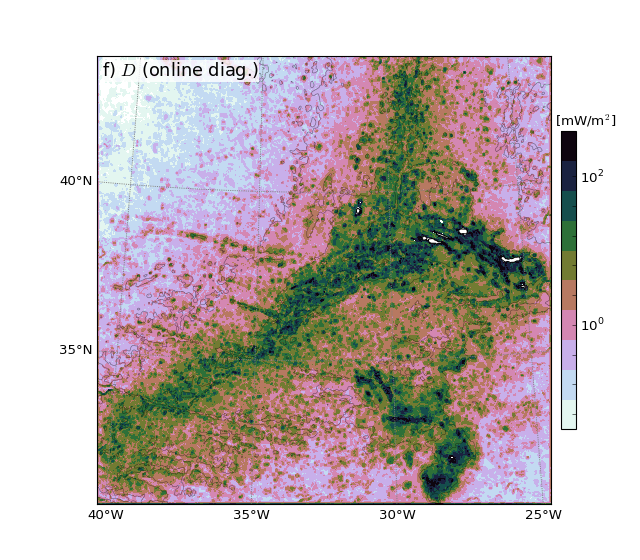

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/lib/python3/dist-packages/matplotlib/contour.py:1537: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)
/usr/lib/python3/dist-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


In [44]:
### plot for paper / need to evaluate dKE on same points as dAPE
toplot = data['ke_hdiff'] + data['ke_vmix'] + data['ke_drag'] #

toplot = (-toplot[eta,:][:,xi] + dape)*1e3 # mW/m^2

print("total dissip (mean): {0:.1f} GW ({1:.2f} mW/m^2)".format(
            (np.nansum(toplot/pm[eta,:][:,xi]/pn[eta,:][:,xi]*4))/1e12, np.nanmean(toplot)))

mask = (h>hmin)[eta,:][:,xi]

# plotting parameters
fs       = 12
proj     = 'lcc'
res      = 'i'
stride   = 5
Lx,Ly    = dx*Nx, dy*Ny-20e3 # extend in m
cmap = plt.get_cmap('cubehelix_r') #gist_stern_r
zlevs=[0,2000,3500]
topocol='k'     # isobath. contour color
grdcol='gray'   # grid color
mascale = "log" # 'linear'# 
fs_lab = 16

if mascale == "linear":
    valmax = 0.1
    levels = np.linspace(0,valmax,11)
    levels[0] = levels[1]/2
elif mascale == 'log':
    valmin = 4e-2
    valmax = 4e2
    levels = np.logspace(np.log10(valmin),np.log10(valmax),11)
    
fig = plt.figure(figsize=(8,7))
ax = plt.subplot(111)
bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),
        lat_0=lat.mean(),width=Lx,height=Ly)
xx, yy = bm(lon[:,xi][eta,:], lat[:,xi][eta,:])
bm.drawcoastlines(color='black')
bm.fillcontinents(color='white')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)

bm.contour(xx,yy,h[:,xi][eta,:],zlevs,colors=topocol,linewidths=0.5,alpha=0.5)
if mascale == 'linear':
    hpc = bm.contourf(xx,yy,np.ma.masked_array(toplot,~mask),levels,\
                      cmap=cmap,extend='max',linestyles=None)
    hcb = bm.colorbar(hpc)#,extend="max")
    hcb.set_ticks(np.r_[0,hcb.get_ticks()])
    hcb.formatter.set_powerlimits((-1, 1))
    hcb.formatter.set_useMathText(True)
    hcb.update_ticks()
elif mascale == 'log':
    hpc = bm.contourf(xx,yy,np.ma.masked_array(toplot,~mask),levels,\
                      cmap=cmap, norm=mpl.colors.LogNorm(), linestyles=None)
    
    hcb = plt.colorbar(hpc,extend="both", fraction=.03, pad=.02)
    hcb.set_ticks(levels/4)
    hcb.update_ticks()
for item in hpc.collections:
    item.set_rasterized('True')
hcb.ax.tick_params(labelsize=fs)
hcb.ax.set_title("\t"+r'[mW/m$^2$]', fontsize=fs, ha="center")

# this is for paper: add label
ax.text(.01, .99, r"f) $D$ (online diag.)", transform=ax.transAxes, ha="left", \
        va="top", bbox=dict(facecolor='w', edgecolor='None', pad=.01, alpha=.8), fontsize=fs_lab)

if dosavefig:
    fig.savefig("pictures/paper/{}_DiagDiss_wape.png".format(simul), \
                magnification="auto", bbox_inches="tight", dpi=150)
    print("figure saved in {}".format("pictures/paper/{}_DiagDiss_wape.png".format(simul)))

In [43]:
np.logspace(np.log10(valmin),np.log10(valmax),11)

array([4.00000000e-02, 1.00475457e-01, 2.52382938e-01, 6.33957277e-01,
       1.59242868e+00, 4.00000000e+00, 1.00475457e+01, 2.52382938e+01,
       6.33957277e+01, 1.59242868e+02, 4.00000000e+02])

In [39]:
[print(item) for item in hcb.ax.get_yticklabels()]

Text(1,0.0418378,'')
Text(1,0.132747,'')
Text(1,0.223656,'')
Text(1,0.314565,'')
Text(1,0.405474,'')
Text(1,0.496383,'')
Text(1,0.587292,'')
Text(1,0.678201,'')
Text(1,0.76911,'')
Text(1,0.86002,'$\\mathdefault{10^{2}}$')


[None, None, None, None, None, None, None, None, None, None]

In [23]:
dir(hcb.ax)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_axisbg',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_current_image',
 '_cursorProps',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_legend_handles',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_hold',
 '_init_axis',
 '_label',
 '_left_title',
 '_make_twin_axes',
 '_mouseover',
 '_navigate',
 '_navigate_mode',
 '_

In [45]:
dosavefig = True
if dosavefig:
    fig.savefig("pictures/paper/{}_DiagDiss_wape_newcb.png".format(simul), \
                magnification="auto", bbox_inches="tight", dpi=150)
    print("figure saved in {}".format("pictures/paper/{}_DiagDiss_wape.png".format(simul)))

figure saved in pictures/paper/luckym2_DiagDiss_wape.png


## compute per domain and save result in dataframe


In [4]:
# load domains, dataframe and declare useful functions

with open(doms_file, "r") as fp:
    mydoms = json.load(fp)
      
# unfold subdomains
doms, nams = [], []
for key,val in mydoms.items():
    if key == "ridges":
        for ido,dom in enumerate(val):
            doms.append(dom)
            nams.append(key.rstrip("s")+str(ido+1))
    else:
        doms.append(val)
        nams.append(key)

if os.path.isfile(pdatout+".pkl"):
    datfra = pd.read_pickle(pdatout+".pkl")
    print("loaded dataframe from pickle")
elif os.path.isfile(pdatout+".csv"):
    datfra = pd.read_csv(pdatout+".csv", header=[0,1], index_col=0)
    print("loaded dataframe from pickle")
else:
    datfra = pd.DataFrame(index=['full']+nams, columns=['dKE','dPE','hdiff','vmix','drag'])
    print("created dataframe")


# local routines (need lon, lat before for convienence)
def coord_to_pix(pos, lon=lon, lat=lat):
    return np.unravel_index(((lon-pos[0])**2+(lat-pos[1])**2).argmin(), lon.shape)[::-1]

def poly_to_mask(poly,shape):
    img = Image.new('1',shape)
    ImageDraw.Draw(img).polygon(poly, outline=1, fill=1)
    return np.array(img)

def polycoord_tomask(coord,lon,lat):
    poly = [coord_to_pix(item, lon, lat) for item in coord]
    return poly_to_mask(poly,lon.shape)

def get_domean(field, dom, lon=lon, lat=lat, masksup=(h>hmin)):
    mask = polycoord_tomask(dom, lon, lat)
    if masksup is not None: mask *= masksup
    return np.nanmean(field[...,mask], axis=(-1))


loaded dataframe from pickle


In [5]:
# compute mean field per subdomain
for dom,nam in zip(doms,nams):
    for var in ["hdiff","vmix","drag"]:
        datfra[var][nam] = -get_domean(data['ke_'+var], dom, lon=lon, lat=lat, masksup=(h>hmin))
    datfra["dKE"][nam] = -get_domean(data['ke_hdiff'] + data['ke_vmix'] + data['ke_drag'] \
                                , dom, lon=lon, lat=lat, masksup=(h>hmin))
    datfra["dPE"][nam] = get_domean(dape, dom, lon=lon[:,xi][eta,:] \
                                   , lat=lat[:,xi][eta,:], masksup=(h[:,xi][eta,:]>hmin))
for var in ["hdiff","vmix","drag"]:
    datfra[var]["full"] = -np.nanmean(data['ke_'+var][h>hmin])
    datfra["dKE"]["full"] = -np.nanmean((data['ke_hdiff'] + data['ke_vmix'] + data['ke_drag'])[h>hmin])
    datfra["dPE"]["full"] = np.nanmean(dape[h[:,xi][eta,:]>hmin])
    
datfra

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/lahaye/Coding/virt

,dKE,dPE,hdiff,vmix,drag,KE_bclin,PE_bclin,divF_bc,Cterm,Diss_bc,Ctlin,Et_bclin,dEt
full,0.00325244,0.00108554,0.00194897,0.000268469,0.001035,1.740593,0.822325,1.103927e-03,0.005567,0.004462,0.006314,2.562918,NaN
seamounts,0.013867,0.00354191,0.00919045,0.00127304,0.00340352,3.477778,1.988690,2.048810e-02,0.038978,0.018490,0.034230,5.466468,NaN
ridge1,0.00516693,0.00125895,0.00358393,0.000372218,0.00121078,1.669531,0.950798,3.340112e-04,0.007541,0.007207,0.008119,2.620329,NaN
ridge2,0.00790172,0.00235309,0.0048576,0.000586827,0.00245729,2.443235,1.181840,-6.291463e-04,0.010757,0.011386,0.011134,3.625075,NaN
ridge3,0.00871345,0.00307468,0.00461894,0.000750977,0.00334352,2.474018,1.103683,6.426644e-04,0.012551,0.011912,0.014123,3.577701,NaN
ridge4,0.00437155,0.00126774,0.00246254,0.000286318,0.0016227,2.211587,0.847407,1.400159e-03,0.007729,0.006329,0.007184,3.058994,NaN
islands,0.0143092,0.00527427,0.00748817,0.00141881,0.00540225,3.123073,1.490643,2.804494e-03,0.020724,0.017947,0.042325,4.613716,NaN
plain,0.000125692,3.9498e-05,5.8916e-05,9.69303e-06,5.70832e-05,0.982061,0.381644,-8.494168e-07,0.000422,0.000423,0.000154,1.363706,NaN


In [6]:
# store dataframe
datfra.to_csv(pdatout+".csv") # problem with csv, list are read as str
datfra.to_pickle(pdatout+".pkl")

In [7]:
datfra["dKE"]/datfra["dPE"], (1/12.42**2)

(full         2.99614
 seamounts    3.91512
 ridge1       4.10416
 ridge2       3.35802
 ridge3       2.83393
 ridge4        3.4483
 islands      2.71302
 plain        3.18224
 dtype: object, 0.00648271319698891)

In [76]:
om, f0 = 1./12.42, 2./24*np.sin(np.deg2rad(37))
(om**2+f0**2)/(om**2-f0**2)

2.267854711707936